In [1]:
#Inspired by https://avandekleut.github.io/vae/
import torch
import torch.nn as nn
import torch.utils
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from tqdm import tqdm

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


In [3]:
class FF(nn.Module):
    def __init__(self,dim1,dim2,dim3):
        super().__init__()
        self.main = nn.Sequential(
            nn.Linear(in_features=dim1, out_features=dim2),
            nn.ReLU(),
            nn.Linear(in_features=dim2, out_features=dim3)
        )

    def forward(self, input):
        return self.main(input)


tmp = FF(28*28,512,2)
print(tmp)
print(tmp(torch.rand(10,1,28*28)).shape)

FF(
  (main): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=2, bias=True)
  )
)
torch.Size([10, 1, 2])


In [4]:
class Autoencoder(nn.Module):
    def __init__(self, dim1, dim2, dim3):
        super(Autoencoder, self).__init__()
        self.encoder = FF(dim1, dim2, dim3)

        self.decoder = nn.Sequential(
            FF(dim3, dim2, dim1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

tmp = Autoencoder(28*28,512,2)
print(tmp)
print(tmp(torch.rand(10,1,28*28)).shape)

Autoencoder(
  (encoder): FF(
    (main): Sequential(
      (0): Linear(in_features=784, out_features=512, bias=True)
      (1): ReLU()
      (2): Linear(in_features=512, out_features=2, bias=True)
    )
  )
  (decoder): Sequential(
    (0): FF(
      (main): Sequential(
        (0): Linear(in_features=2, out_features=512, bias=True)
        (1): ReLU()
        (2): Linear(in_features=512, out_features=784, bias=True)
      )
    )
    (1): Sigmoid()
  )
)
torch.Size([10, 1, 784])


In [5]:



class PCAEncoder:
    def __init__(self, dim1, _, dim3):
        super(PCAEncoder, self).__init__()
        self.dim1 = dim1
        self.dim3 = dim3
        self.pca = PCA(n_components=self.dim3)
        self.mean = None
        self.components = None
        self.explained_variance = None

    def fit(self, data_loader):
        all_data = []
        for data, _ in data_loader:
            all_data.append(data.view(-1, self.dim1))  # Flatten and collect data

        all_data = torch.cat(all_data, dim=0).numpy()
        self.pca.fit(all_data)

        self.mean = torch.tensor(self.pca.mean_, dtype=torch.float32)
        self.components = torch.tensor(self.pca.components_.T, dtype=torch.float32)
        self.explained_variance = torch.tensor(self.pca.explained_variance_, dtype=torch.float32)


    def __call__(self, x):
        if self.mean is None or self.components is None:
            raise RuntimeError("PCAEncoder is not fitted yet. Please call `fit` with training data first.")

        x = x.view(-1, self.dim1)

        x_centered = x - self.mean
        encoded = torch.mm(x_centered, self.components)
        # Reshape to [batch, 1, dim3]
        return encoded.view(-1, 1, self.dim3)

class PCADecoder:
    def __init__(self, dim1, _, dim3):
        super().__init__()
        self.dim1 = dim1  # Original dimension of the data
        self.dim3 = dim3  # Reduced dimension (number of principal components)

        # These will be set from the encoder after fitting
        self.mean = None
        self.components = None
        self.explained_variance = None

    def set_params(self, mean, components, explained_variance):
        self.mean = mean
        self.components = components
        self.explained_variance = explained_variance

    def __call__(self, z):
        if self.mean is None or self.components is None or self.explained_variance is None:
            raise RuntimeError("PCADecoder parameters not set. Ensure you set 'mean', 'components', and 'explained_variance' from the encoder.")

        # Reshape z if it's not already (num_samples, num_components)
        z = z.view(-1, self.dim3)

        # Reconstruction from PCA latent space
        x_reconstructed = torch.mm(z * torch.sqrt(self.explained_variance), self.components.T) + self.mean
        # image_dimension = int(self.dim1**0.5)  # e.g., 28 for 28x28 images
        return x_reconstructed.view(-1, 1, self.dim1)



In [6]:
def train(data_loader, model, optimizer, loss_function, epochs=20):
    model.to(device) # GPU
    losses = []
    for epoch in range(epochs):
        for i, (x, y) in enumerate(data_loader):
            x = x.to(device) # GPU
            optimizer.zero_grad()
            x_hat = model(x)
            loss = loss_function(x, x_hat)
            losses.append(loss.clone().detach().cpu().numpy())
            loss.backward()
            optimizer.step()
            if i % 100 == 0:
                print(f"{epoch}/{i}: {loss}")
    return (model, losses)

def calculate_pca_loss(data_loader, encoder, decoder, loss_function):
    total_loss = 0
    with torch.no_grad():
        for batch_idx, (x, _) in enumerate(data_loader):
            z = encoder(x)
            x_hat = decoder(z)
            loss = loss_function(x_hat, x)
            total_loss += loss.item()
    average_loss = total_loss / len(data_loader)
    return average_loss

In [7]:
def plot_latent(data_loader, encoder, dim1=0, dim2=1, num_batches=100):
    for i, (x, y) in enumerate(data_loader):
        z = encoder(x.to(device))
        z = z.to('cpu').detach().numpy()
        plt.scatter(z[:, 0, dim1], z[:, 0, dim2], c=y, alpha=0.5)
        if i > num_batches:
            plt.colorbar()
            break

In [8]:
def plot_reconstructed(decoder, w, h, r0=(-10, 10), r1=(-10, 10), n=12, latent_dim=2):
    img = np.zeros((n*w, n*h))
    for i, y in enumerate(np.linspace(*r1, n)):
        for j, x in enumerate(np.linspace(*r0, n)):
            if latent_dim > 2:
                z_values = np.random.randn(latent_dim)  # Random values, change this according to your needs
                z = torch.Tensor([z_values]).view(1, 1, latent_dim).to(device)
            else:
                z = torch.Tensor([[x, y]]).view(1,1,2).to(device)
            x_hat = decoder(z)
            x_hat = x_hat.reshape(w, h).to('cpu').detach().numpy()
            img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat
    plt.imshow(img, extent=[*r0, *r1])

In [9]:
# Transform
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: torch.flatten(x,start_dim=-2))
])

data = datasets.MNIST('./data',transform=transform,download=True)

n, w, h = data.data.shape

data_loader = torch.utils.data.DataLoader(data, batch_size=128, shuffle=True)
losses_pca = []
losses_nn = []
latent_dims = range(1, 21)

epochs = 20
for latent_dim in tqdm(latent_dims):
  pca_encoder = PCAEncoder(w*h, 512, latent_dim)
  pca_encoder.fit(data)
  pca_decoder = PCADecoder(w*h, 512, latent_dim)
  pca_decoder.set_params(pca_encoder.mean, pca_encoder.components, pca_encoder.explained_variance)
  pca_loss = calculate_pca_loss(data_loader, pca_encoder, pca_decoder, nn.MSELoss())
  losses_pca.append(pca_loss)


100%|██████████| 20/20 [02:25<00:00,  7.29s/it]


In [10]:
for latent_dim in tqdm(latent_dims):
  model = Autoencoder(w*h, 512, latent_dim)

  optimizer = torch.optim.Adam(model.parameters())

  loss_function = torch.nn.MSELoss()

  (autoencoder, losses) = train(data_loader, model, optimizer, loss_function, epochs)
  losses_nn.append(losses[-1])

  0%|          | 0/20 [00:00<?, ?it/s]

0/0: 0.23666517436504364
0/100: 0.061308156698942184
0/200: 0.05882799252867699
0/300: 0.06145318225026131
0/400: 0.059571508318185806
1/0: 0.05548381805419922
1/100: 0.059451039880514145
1/200: 0.057927947491407394
1/300: 0.0569949634373188
1/400: 0.057881977409124374
2/0: 0.05688643082976341
2/100: 0.058544423431158066
2/200: 0.053828299045562744
2/300: 0.05728191137313843
2/400: 0.05413370579481125
3/0: 0.05719881132245064
3/100: 0.05573885887861252
3/200: 0.05671386793255806
3/300: 0.05514603108167648
3/400: 0.05527631938457489
4/0: 0.053381793200969696
4/100: 0.05634000524878502
4/200: 0.056429166346788406
4/300: 0.054097626358270645
4/400: 0.05608680471777916
5/0: 0.054318998008966446
5/100: 0.0556933768093586
5/200: 0.054212138056755066
5/300: 0.05494072660803795
5/400: 0.05661708489060402
6/0: 0.054679565131664276
6/100: 0.052347373217344284
6/200: 0.05224526673555374
6/300: 0.05148887634277344
6/400: 0.054994117468595505
7/0: 0.0547071248292923
7/100: 0.05581533536314964
7/200

  5%|▌         | 1/20 [16:58<5:22:26, 1018.23s/it]

0/0: 0.23159754276275635
0/100: 0.05815644562244415
0/200: 0.05429666489362717
0/300: 0.051457617431879044
0/400: 0.05297955870628357
1/0: 0.050134893506765366
1/100: 0.04712912067770958
1/200: 0.04838886111974716
1/300: 0.0459493026137352
1/400: 0.04672964662313461
2/0: 0.047161102294921875
2/100: 0.04636351764202118
2/200: 0.045106157660484314
2/300: 0.04641231894493103
2/400: 0.04610592871904373
3/0: 0.04569900408387184
3/100: 0.04902182146906853
3/200: 0.04665293172001839
3/300: 0.04665463790297508
3/400: 0.0430721640586853
4/0: 0.04429974779486656
4/100: 0.04366833344101906
4/200: 0.04309110715985298
4/300: 0.04635278508067131
4/400: 0.04452934116125107
5/0: 0.044830020517110825
5/100: 0.039808809757232666
5/200: 0.043728943914175034
5/300: 0.04003000631928444
5/400: 0.04383956268429756
6/0: 0.04003862291574478
6/100: 0.04154282808303833
6/200: 0.04195751994848251
6/300: 0.044218480587005615
6/400: 0.04448820278048515
7/0: 0.04169991612434387
7/100: 0.042024340480566025
7/200: 0.0

 10%|█         | 2/20 [22:18<3:02:14, 607.49s/it] 

0/0: 0.23146452009677887
0/100: 0.053405631333589554
0/200: 0.045536331832408905
0/300: 0.043277714401483536
0/400: 0.04372972249984741
1/0: 0.043873418122529984
1/100: 0.04053888097405434
1/200: 0.03887253999710083
1/300: 0.039088282734155655
1/400: 0.03820417448878288
2/0: 0.03792669624090195
2/100: 0.03876194730401039
2/200: 0.037901125848293304
2/300: 0.03785892203450203
2/400: 0.035514041781425476
3/0: 0.037677645683288574
3/100: 0.03546551614999771
3/200: 0.04055188223719597
3/300: 0.03293333575129509
3/400: 0.03760923817753792
4/0: 0.034640680998563766
4/100: 0.036500006914138794
4/200: 0.03579683601856232
4/300: 0.03543495759367943
4/400: 0.038477081805467606
5/0: 0.03334764763712883
5/100: 0.037642545998096466
5/200: 0.036987196654081345
5/300: 0.034122977405786514
5/400: 0.037187740206718445
6/0: 0.03587077930569649
6/100: 0.03478037938475609
6/200: 0.03713175281882286
6/300: 0.03519093617796898
6/400: 0.0352792926132679
7/0: 0.037698015570640564
7/100: 0.03583270683884621
7/

 15%|█▌        | 3/20 [28:08<2:18:53, 490.22s/it]

0/0: 0.2322498857975006
0/100: 0.04920492693781853
0/200: 0.0411158911883831
0/300: 0.0386805534362793
0/400: 0.03382641449570656
1/0: 0.03845866024494171
1/100: 0.038040488958358765
1/200: 0.03227913752198219
1/300: 0.032481785863637924
1/400: 0.03330552205443382
2/0: 0.0340740866959095
2/100: 0.033491961658000946
2/200: 0.03133465722203255
2/300: 0.029558569192886353
2/400: 0.03330495208501816
3/0: 0.03212839737534523
3/100: 0.03153412789106369
3/200: 0.03348255529999733
3/300: 0.03044009394943714
3/400: 0.03041517548263073
4/0: 0.03226268291473389
4/100: 0.03314058482646942
4/200: 0.031107308343052864
4/300: 0.03111335262656212
4/400: 0.031148074194788933
5/0: 0.02918228879570961
5/100: 0.03002913109958172
5/200: 0.03123781643807888
5/300: 0.032074082642793655
5/400: 0.029878076165914536
6/0: 0.031753603368997574
6/100: 0.029807191342115402
6/200: 0.029539749026298523
6/300: 0.028924886137247086
6/400: 0.03048941120505333
7/0: 0.03338697552680969
7/100: 0.029626689851284027
7/200: 0

 20%|██        | 4/20 [1:19:41<6:44:40, 1517.54s/it]

0/0: 0.231631800532341
0/100: 0.04875166714191437
0/200: 0.037001702934503555
0/300: 0.03318048641085625
0/400: 0.029870321974158287
1/0: 0.0330197773873806
1/100: 0.03096441552042961
1/200: 0.02966773323714733
1/300: 0.03118816390633583
1/400: 0.029965335503220558
2/0: 0.026506628841161728
2/100: 0.026989707723259926
2/200: 0.029296524822711945
2/300: 0.02835293859243393
2/400: 0.027270402759313583
3/0: 0.027556048706173897
3/100: 0.028114138171076775
3/200: 0.025899138301610947
3/300: 0.026792407035827637
3/400: 0.02551727183163166
4/0: 0.028025852516293526
4/100: 0.027469763532280922
4/200: 0.029170114547014236
4/300: 0.025982951745390892
4/400: 0.02818753756582737
5/0: 0.030614718794822693
5/100: 0.025846844539046288
5/200: 0.024768978357315063
5/300: 0.0276974905282259
5/400: 0.024977929890155792
6/0: 0.025728654116392136
6/100: 0.0255427286028862
6/200: 0.026072097942233086
6/300: 0.028408098965883255
6/400: 0.025214049965143204
7/0: 0.02524774894118309
7/100: 0.02810312062501907

 25%|██▌       | 5/20 [1:22:47<4:19:21, 1037.42s/it]

0/0: 0.23266437649726868
0/100: 0.04635491594672203
0/200: 0.0353001207113266
0/300: 0.03545386344194412
0/400: 0.027782386168837547
1/0: 0.02990865148603916
1/100: 0.027651391923427582
1/200: 0.02888413332402706
1/300: 0.027888011187314987
1/400: 0.025698116049170494
2/0: 0.02868060953915119
2/100: 0.025464631617069244
2/200: 0.025041542947292328
2/300: 0.025663569569587708
2/400: 0.025761662051081657
3/0: 0.02279486693441868
3/100: 0.0234884824603796
3/200: 0.02556137926876545
3/300: 0.023628856986761093
3/400: 0.02327275276184082
4/0: 0.024180421605706215
4/100: 0.02319728396832943
4/200: 0.02400052547454834
4/300: 0.0237068273127079
4/400: 0.0239079799503088
5/0: 0.02280711568892002
5/100: 0.023257723078131676
5/200: 0.021035607904195786
5/300: 0.022537145763635635
5/400: 0.02359176240861416
6/0: 0.02249225229024887
6/100: 0.02622177079319954
6/200: 0.02258879318833351
6/300: 0.020706795156002045
6/400: 0.023090079426765442
7/0: 0.024950185790657997
7/100: 0.019164331257343292
7/20

 30%|███       | 6/20 [1:35:22<3:39:41, 941.56s/it] 

0/0: 0.23228532075881958
0/100: 0.04214106872677803
0/200: 0.03294016048312187
0/300: 0.02942003682255745
0/400: 0.030082575976848602
1/0: 0.025676347315311432
1/100: 0.026642410084605217
1/200: 0.02456582523882389
1/300: 0.02652924694120884
1/400: 0.025026485323905945
2/0: 0.024051295593380928
2/100: 0.0264158695936203
2/200: 0.021998438984155655
2/300: 0.022448061034083366
2/400: 0.023823732510209084
3/0: 0.021922418847680092
3/100: 0.02103201299905777
3/200: 0.019558947533369064
3/300: 0.021190619096159935
3/400: 0.02121506631374359
4/0: 0.02131611667573452
4/100: 0.020286068320274353
4/200: 0.022202681750059128
4/300: 0.021101729944348335
4/400: 0.024231985211372375
5/0: 0.020885435864329338
5/100: 0.02347281575202942
5/200: 0.02149796672165394
5/300: 0.02176898904144764
5/400: 0.020509567111730576
6/0: 0.023209314793348312
6/100: 0.021665118634700775
6/200: 0.021056970581412315
6/300: 0.019383631646633148
6/400: 0.020661208778619766
7/0: 0.018982546404004097
7/100: 0.0211889501661

 35%|███▌      | 7/20 [1:38:46<2:31:43, 700.29s/it]

0/0: 0.2315872609615326
0/100: 0.048268482089042664
0/200: 0.03287506103515625
0/300: 0.026521405205130577
0/400: 0.02657877840101719
1/0: 0.024972034618258476
1/100: 0.025507105514407158
1/200: 0.025552568957209587
1/300: 0.023428453132510185
1/400: 0.0229477696120739
2/0: 0.023518452420830727
2/100: 0.022471236065030098
2/200: 0.022991487756371498
2/300: 0.022346390411257744
2/400: 0.02089959941804409
3/0: 0.020649656653404236
3/100: 0.020177023485302925
3/200: 0.019569935277104378
3/300: 0.019242292270064354
3/400: 0.019619988277554512
4/0: 0.019907085224986076
4/100: 0.0185545664280653
4/200: 0.018997270613908768
4/300: 0.01672259159386158
4/400: 0.020341550931334496
5/0: 0.01867356151342392
5/100: 0.01975417695939541
5/200: 0.019316857680678368
5/300: 0.020005637779831886
5/400: 0.018120240420103073
6/0: 0.019012747332453728
6/100: 0.01712794043123722
6/200: 0.020103730261325836
6/300: 0.01716887764632702
6/400: 0.01833498664200306
7/0: 0.016634641215205193
7/100: 0.01889718882739

 40%|████      | 8/20 [1:42:07<1:48:14, 541.24s/it]

0/0: 0.2315625548362732
0/100: 0.04126577079296112
0/200: 0.030139541253447533
0/300: 0.02611858956515789
0/400: 0.026253892108798027
1/0: 0.023802565410733223
1/100: 0.022179175168275833
1/200: 0.022198759019374847
1/300: 0.02166786417365074
1/400: 0.02034495584666729
2/0: 0.020172156393527985
2/100: 0.02194059081375599
2/200: 0.01916717179119587
2/300: 0.01997549831867218
2/400: 0.020771309733390808
3/0: 0.019487246870994568
3/100: 0.017241893336176872
3/200: 0.017068766057491302
3/300: 0.01784026063978672
3/400: 0.019205821678042412
4/0: 0.018536144867539406
4/100: 0.019850390031933784
4/200: 0.018137918785214424
4/300: 0.017535243183374405
4/400: 0.01901782862842083
5/0: 0.01815737597644329
5/100: 0.016546983271837234
5/200: 0.016348930075764656
5/300: 0.018641334027051926
5/400: 0.017915088683366776
6/0: 0.016345134004950523
6/100: 0.017646392807364464
6/200: 0.018360605463385582
6/300: 0.018391845747828484
6/400: 0.01746033877134323
7/0: 0.015997808426618576
7/100: 0.016306299716

 45%|████▌     | 9/20 [1:58:30<2:04:33, 679.38s/it]

0/0: 0.2317725419998169
0/100: 0.04518885165452957
0/200: 0.029588231816887856
0/300: 0.02409038506448269
0/400: 0.023029623553156853
1/0: 0.019753826782107353
1/100: 0.021097229793667793
1/200: 0.018608402460813522
1/300: 0.022092029452323914
1/400: 0.021024474874138832
2/0: 0.020456207916140556
2/100: 0.018831739202141762
2/200: 0.018122276291251183
2/300: 0.02011324279010296
2/400: 0.02015271782875061
3/0: 0.01840050145983696
3/100: 0.017795369029045105
3/200: 0.017308466136455536
3/300: 0.017371023073792458
3/400: 0.016581958159804344
4/0: 0.017207935452461243
4/100: 0.016613710671663284
4/200: 0.015957998111844063
4/300: 0.015484399162232876
4/400: 0.016800779849290848
5/0: 0.015018243342638016
5/100: 0.016260873526334763
5/200: 0.016431421041488647
5/300: 0.014919757843017578
5/400: 0.015908246859908104
6/0: 0.015546156093478203
6/100: 0.015298616141080856
6/200: 0.015440237708389759
6/300: 0.01612907089293003
6/400: 0.01661400869488716
7/0: 0.015821967273950577
7/100: 0.01376461

 50%|█████     | 10/20 [2:01:24<1:27:13, 523.35s/it]

0/0: 0.2328207790851593
0/100: 0.04433339834213257
0/200: 0.02689889445900917
0/300: 0.02341167815029621
0/400: 0.023237833753228188
1/0: 0.020174827426671982
1/100: 0.021024368703365326
1/200: 0.018897630274295807
1/300: 0.018983814865350723
1/400: 0.01982610858976841
2/0: 0.01873377338051796
2/100: 0.018490120768547058
2/200: 0.01722884364426136
2/300: 0.017627013847231865
2/400: 0.016808010637760162
3/0: 0.016615912318229675
3/100: 0.014810649678111076
3/200: 0.014981203712522984
3/300: 0.016553007066249847
3/400: 0.01873401738703251
4/0: 0.015321739949285984
4/100: 0.01463643740862608
4/200: 0.016116103157401085
4/300: 0.018419411033391953
4/400: 0.0152228819206357
5/0: 0.015368398278951645
5/100: 0.014972040429711342
5/200: 0.014906637370586395
5/300: 0.013441662304103374
5/400: 0.014281355775892735
6/0: 0.015208962373435497
6/100: 0.014267130754888058
6/200: 0.014682229608297348
6/300: 0.01385846920311451
6/400: 0.015300285071134567
7/0: 0.013554763048887253
7/100: 0.014952970668

 55%|█████▌    | 11/20 [2:39:16<2:38:47, 1058.57s/it]

0/0: 0.23108525574207306
0/100: 0.04185054078698158
0/200: 0.02682770974934101
0/300: 0.023165471851825714
0/400: 0.023611662909388542
1/0: 0.019141454249620438
1/100: 0.020150505006313324
1/200: 0.01911117136478424
1/300: 0.01967155560851097
1/400: 0.018572760745882988
2/0: 0.014991696923971176
2/100: 0.016563357785344124
2/200: 0.01706155762076378
2/300: 0.017780285328626633
2/400: 0.01567513681948185
3/0: 0.01685156673192978
3/100: 0.01627626270055771
3/200: 0.015994973480701447
3/300: 0.014748808927834034
3/400: 0.0159541554749012
4/0: 0.01548574399203062
4/100: 0.013765673153102398
4/200: 0.01570763997733593
4/300: 0.014023792929947376
4/400: 0.014659387990832329
5/0: 0.015105566009879112
5/100: 0.013592822477221489
5/200: 0.014335655607283115
5/300: 0.013517370447516441
5/400: 0.016214672476053238
6/0: 0.013803534209728241
6/100: 0.01429299172013998
6/200: 0.013429191894829273
6/300: 0.014379933476448059
6/400: 0.015137176029384136
7/0: 0.013225539587438107
7/100: 0.0144089292734

 60%|██████    | 12/20 [2:42:16<1:45:30, 791.31s/it] 

0/0: 0.23119549453258514
0/100: 0.04246549680829048
0/200: 0.02598492056131363
0/300: 0.02170400321483612
0/400: 0.02110837958753109
1/0: 0.01950877718627453
1/100: 0.019475411623716354
1/200: 0.01911146380007267
1/300: 0.016337841749191284
1/400: 0.017420148476958275
2/0: 0.016087211668491364
2/100: 0.01812399923801422
2/200: 0.015273724682629108
2/300: 0.015410634689033031
2/400: 0.014792094007134438
3/0: 0.016838587820529938
3/100: 0.014083817601203918
3/200: 0.014449612237513065
3/300: 0.015086050145328045
3/400: 0.014175918884575367
4/0: 0.014763271436095238
4/100: 0.014250521548092365
4/200: 0.014087960124015808
4/300: 0.013642556965351105
4/400: 0.01456692535430193
5/0: 0.014012355357408524
5/100: 0.01356241200119257
5/200: 0.013013215735554695
5/300: 0.013168372213840485
5/400: 0.014570827595889568
6/0: 0.013385939411818981
6/100: 0.014122307300567627
6/200: 0.012302608229219913
6/300: 0.013335936702787876
6/400: 0.012608385644853115
7/0: 0.012461877427995205
7/100: 0.012631099

 65%|██████▌   | 13/20 [2:53:25<1:27:59, 754.17s/it]

0/0: 0.23234029114246368
0/100: 0.045704424381256104
0/200: 0.027369093149900436
0/300: 0.021073563024401665
0/400: 0.018411880359053612
1/0: 0.016954299062490463
1/100: 0.017605166882276535
1/200: 0.017795519903302193
1/300: 0.01660975068807602
1/400: 0.015438556671142578
2/0: 0.016269128769636154
2/100: 0.014161471277475357
2/200: 0.014000438153743744
2/300: 0.015423302538692951
2/400: 0.01428298931568861
3/0: 0.014732908457517624
3/100: 0.014066465198993683
3/200: 0.0151317548006773
3/300: 0.015194790437817574
3/400: 0.014530555345118046
4/0: 0.01277173776179552
4/100: 0.013202755711972713
4/200: 0.013314884155988693
4/300: 0.011970845982432365
4/400: 0.012691767886281013
5/0: 0.012901172041893005
5/100: 0.012753243558108807
5/200: 0.012342696078121662
5/300: 0.012884148396551609
5/400: 0.011829226277768612
6/0: 0.011935134418308735
6/100: 0.012271758168935776
6/200: 0.011407837271690369
6/300: 0.012341571971774101
6/400: 0.011688541620969772
7/0: 0.012263053096830845
7/100: 0.01195

 70%|███████   | 14/20 [2:56:09<57:35, 575.95s/it]  

0/0: 0.23162029683589935
0/100: 0.041788335889577866
0/200: 0.026489051058888435
0/300: 0.020606786012649536
0/400: 0.019875025376677513
1/0: 0.01697738841176033
1/100: 0.0168022308498621
1/200: 0.016635727137327194
1/300: 0.01503567025065422
1/400: 0.01390808168798685
2/0: 0.015186608768999577
2/100: 0.014165998436510563
2/200: 0.01404058001935482
2/300: 0.013995654881000519
2/400: 0.01428619772195816
3/0: 0.013543296605348587
3/100: 0.013245520181953907
3/200: 0.01248773280531168
3/300: 0.014666174538433552
3/400: 0.013155904598534107
4/0: 0.013382112607359886
4/100: 0.013354121707379818
4/200: 0.013054859824478626
4/300: 0.012142343446612358
4/400: 0.01240628119558096
5/0: 0.011779673397541046
5/100: 0.011566661298274994
5/200: 0.01226067915558815
5/300: 0.012241765856742859
5/400: 0.010757860727608204
6/0: 0.01105246227234602
6/100: 0.012055676430463791
6/200: 0.011470429599285126
6/300: 0.010761931538581848
6/400: 0.010467411018908024
7/0: 0.011570309288799763
7/100: 0.01122235506

 75%|███████▌  | 15/20 [2:59:17<38:15, 459.08s/it]

0/0: 0.23000724613666534
0/100: 0.04549950361251831
0/200: 0.025879597291350365
0/300: 0.019252890720963478
0/400: 0.01766933687031269
1/0: 0.01786722242832184
1/100: 0.017625076696276665
1/200: 0.01815769262611866
1/300: 0.01569790579378605
1/400: 0.01502015721052885
2/0: 0.013576768338680267
2/100: 0.013844518922269344
2/200: 0.013230440206825733
2/300: 0.014087486080825329
2/400: 0.012803909368813038
3/0: 0.01308826170861721
3/100: 0.013088179752230644
3/200: 0.012744542211294174
3/300: 0.013014338910579681
3/400: 0.013174796476960182
4/0: 0.011790269054472446
4/100: 0.010872541926801205
4/200: 0.011460287496447563
4/300: 0.012222710996866226
4/400: 0.011368785984814167
5/0: 0.011180910281836987
5/100: 0.010381337255239487
5/200: 0.0121314050629735
5/300: 0.011484268121421337
5/400: 0.010434553027153015
6/0: 0.012564931996166706
6/100: 0.012002445757389069
6/200: 0.011184400878846645
6/300: 0.010110428556799889
6/400: 0.011291292496025562
7/0: 0.009768224321305752
7/100: 0.010733542

 80%|████████  | 16/20 [3:04:29<27:39, 414.87s/it]

0/0: 0.2318878322839737
0/100: 0.04388909041881561
0/200: 0.028507867828011513
0/300: 0.021969884634017944
0/400: 0.01861795410513878
1/0: 0.015362060628831387
1/100: 0.014039294794201851
1/200: 0.015625037252902985
1/300: 0.0149235175922513
1/400: 0.014057249762117863
2/0: 0.013513986952602863
2/100: 0.01339381467550993
2/200: 0.013182100839912891
2/300: 0.012388401664793491
2/400: 0.013367553241550922
3/0: 0.012487105093896389
3/100: 0.013495261780917645
3/200: 0.01169800478965044
3/300: 0.011627912521362305
3/400: 0.01240171305835247
4/0: 0.011296925134956837
4/100: 0.010270893573760986
4/200: 0.010915672406554222
4/300: 0.012808220461010933
4/400: 0.011143259704113007
5/0: 0.011036957614123821
5/100: 0.010563756339251995
5/200: 0.010078154504299164
5/300: 0.010446385480463505
5/400: 0.009805917739868164
6/0: 0.010326074436306953
6/100: 0.010718881152570248
6/200: 0.010701722465455532
6/300: 0.010369483381509781
6/400: 0.010645450092852116
7/0: 0.010846234858036041
7/100: 0.01015860

 85%|████████▌ | 17/20 [3:07:24<17:07, 342.62s/it]

0/0: 0.23234543204307556
0/100: 0.04542917013168335
0/200: 0.02639159932732582
0/300: 0.021021287888288498
0/400: 0.017502712085843086
1/0: 0.01648591458797455
1/100: 0.015973662957549095
1/200: 0.014423111453652382
1/300: 0.01439935714006424
1/400: 0.013499987311661243
2/0: 0.01291786041110754
2/100: 0.012050061486661434
2/200: 0.012107455171644688
2/300: 0.011337135918438435
2/400: 0.01044539362192154
3/0: 0.012066630646586418
3/100: 0.01170094683766365
3/200: 0.010500446893274784
3/300: 0.011476418003439903
3/400: 0.011285814456641674
4/0: 0.009514960460364819
4/100: 0.01136680319905281
4/200: 0.009936347603797913
4/300: 0.010826127603650093
4/400: 0.010630865581333637
5/0: 0.010359924286603928
5/100: 0.009333387017250061
5/200: 0.009727049618959427
5/300: 0.00956640299409628
5/400: 0.010675163008272648
6/0: 0.010535298846662045
6/100: 0.009481404908001423
6/200: 0.009152430109679699
6/300: 0.010467424988746643
6/400: 0.010183910839259624
7/0: 0.00932152010500431
7/100: 0.0097577683

 90%|█████████ | 18/20 [3:10:23<09:47, 293.60s/it]

0/0: 0.23066341876983643
0/100: 0.04720911383628845
0/200: 0.02669304795563221
0/300: 0.01928834244608879
0/400: 0.01749548502266407
1/0: 0.016001705080270767
1/100: 0.01490774005651474
1/200: 0.013287264853715897
1/300: 0.013584990985691547
1/400: 0.014073102734982967
2/0: 0.012600453570485115
2/100: 0.012353675439953804
2/200: 0.011599287390708923
2/300: 0.010940680280327797
2/400: 0.011023498140275478
3/0: 0.011299117468297482
3/100: 0.011053705587983131
3/200: 0.01058821938931942
3/300: 0.010722445324063301
3/400: 0.010303553193807602
4/0: 0.009251185692846775
4/100: 0.010125478729605675
4/200: 0.009747670963406563
4/300: 0.010135368444025517
4/400: 0.010663095861673355
5/0: 0.00982737261801958
5/100: 0.009168730117380619
5/200: 0.010696944780647755
5/300: 0.010156253352761269
5/400: 0.009934415109455585
6/0: 0.009880714118480682
6/100: 0.009822244755923748
6/200: 0.00979091227054596
6/300: 0.009359032846987247
6/400: 0.00887591578066349
7/0: 0.009152143262326717
7/100: 0.009112643

 95%|█████████▌| 19/20 [3:55:07<16:51, 1011.41s/it]

0/0: 0.23300667107105255
0/100: 0.04297514259815216
0/200: 0.026790501549839973
0/300: 0.02045927196741104
0/400: 0.015728823840618134
1/0: 0.016430560499429703
1/100: 0.013476955704391003
1/200: 0.013550546951591969
1/300: 0.013416730798780918
1/400: 0.012811641208827496
2/0: 0.011642822995781898
2/100: 0.011989139951765537
2/200: 0.011162412352859974
2/300: 0.012266171164810658
2/400: 0.011226041242480278
3/0: 0.010394363664090633
3/100: 0.010060322470963001
3/200: 0.010697562247514725
3/300: 0.00939866341650486
3/400: 0.00987248681485653
4/0: 0.009406663477420807
4/100: 0.01015970017760992
4/200: 0.010259315371513367
4/300: 0.009029093198478222
4/400: 0.009617377072572708
5/0: 0.008835036307573318
5/100: 0.00948122888803482
5/200: 0.008456790819764137
5/300: 0.007899080403149128
5/400: 0.009684794582426548
6/0: 0.009433509781956673
6/100: 0.00921702291816473
6/200: 0.008296309970319271
6/300: 0.00946804229170084
6/400: 0.009075477719306946
7/0: 0.008123736828565598
7/100: 0.00868201

100%|██████████| 20/20 [3:57:46<00:00, 713.34s/it] 


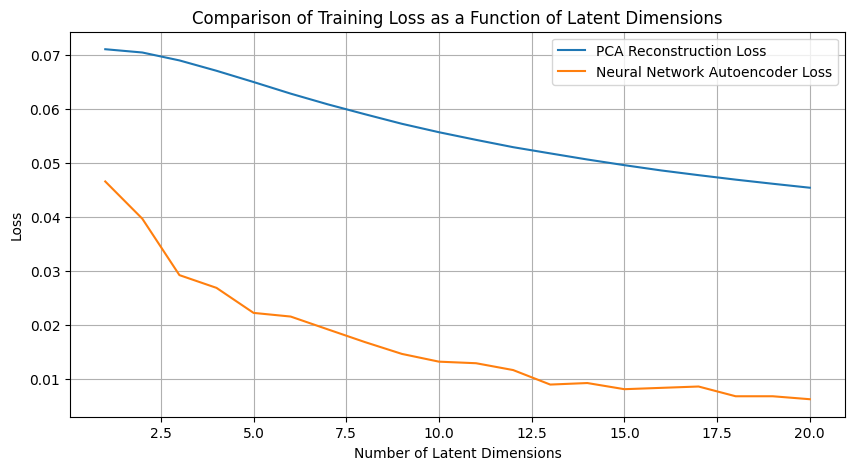

In [21]:
import pickle


# pickle.dump(losses_pca, open('losses_pca.pkl', 'wb'))
# pickle.dump(losses_nn, open('losses_nn.pkl', 'wb'))
# pickle.dump(latent_dims, open('latent_dims.pkl', 'wb'))

losses_pca = pickle.load(open('losses_pca.pkl', 'rb'))
losses_nn = pickle.load(open('losses_nn.pkl', 'rb'))
latent_dims = pickle.load(open('latent_dims.pkl', 'rb'))

plt.figure(figsize=(10, 5))
plt.plot(latent_dims, losses_pca, label='PCA Reconstruction Loss')
plt.plot(latent_dims, losses_nn, label='Neural Network Autoencoder Loss')
plt.title('Comparison of Training Loss as a Function of Latent Dimensions')
plt.xlabel('Number of Latent Dimensions')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

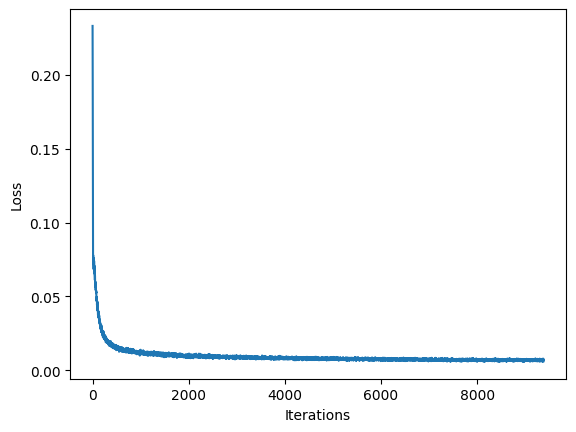

In [12]:
# Defining the Plot Style
plt.xlabel('Iterations')
plt.ylabel('Loss')

# Plotting the losses
plt.plot(losses)

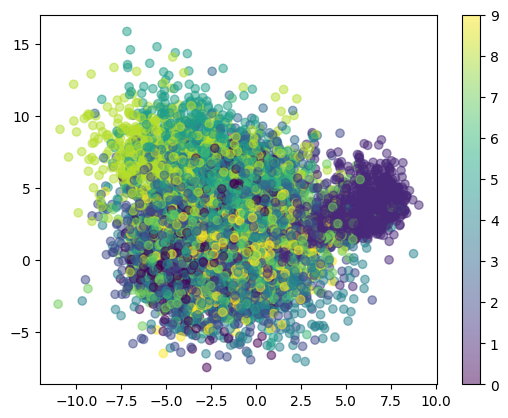

In [13]:
# Plot latent space
plot_latent(data_loader, model.encoder)
plt.savefig('latent.pdf')

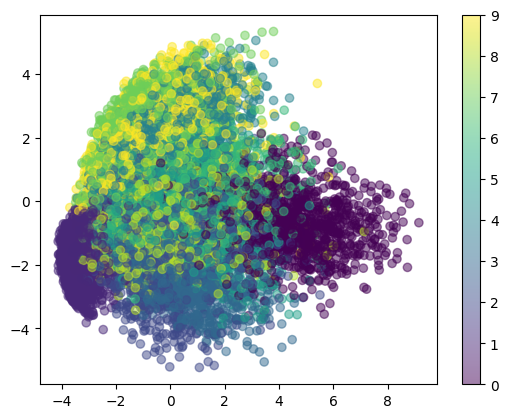

In [14]:
# Plot latent space
plot_latent(data_loader, pca_encoder)
plt.savefig('latent.pdf')

/tmp/ipykernel_1687/3170672098.py:7: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  z = torch.Tensor([z_values]).view(1, 1, latent_dim).to(device)


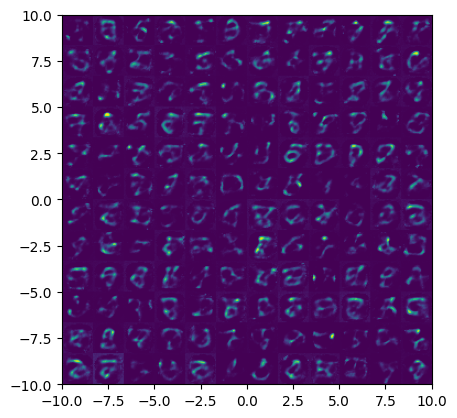

In [15]:
# Generate samples from latent space
plot_reconstructed(model.decoder, w, h, latent_dim=latent_dim)
plt.savefig('reconstruction.pdf')

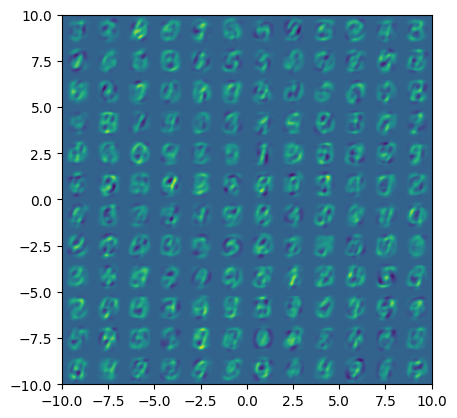

In [16]:
# Generate samples from latent space
plot_reconstructed(pca_decoder, w, h, latent_dim=latent_dim)
plt.savefig('reconstruction.pdf')

In [17]:
# Plot reconstruction error versus number of latent nodes
